In [9]:
import logging
import sys
import nltk  # Here to have a nice missing dependency error message early on
import numpy as np
import pandas as pd
import torch
import pickle

import evaluate
from datasets import load_dataset
from transformers import (
    AutoConfig,
    AutoTokenizer,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    set_seed,
)

from sum_lib import (
    ModelArguments,
    DataTrainingArguments,
    SumTrainer,
    adjust_training_args,
)
from models import (
    T5ForConditionalGeneration,
    DeployT5ForConditionalGeneration,
    LongT5ForConditionalGeneration,
    DeployLongT5ForConditionalGeneration,
)
from util import (
    AdditionalArguments,
    update_autoconfig,
)

from sequence_types.sequence_types import (
    compute_hidden_state_similarities,
    find_sequence_types,
    compute_sequence_metrics
)
from sequence_types.plotting import plot_hidden_state_similarities

logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        handlers=[logging.StreamHandler(sys.stdout)],
    )
logger = logging.getLogger(__name__)

summarization_name_mapping = {
    "amazon_reviews_multi": ("review_body", "review_title"),
    "big_patent": ("description", "abstract"),
    "cnn_dailymail": ("article", "highlights"),
    "orange_sum": ("text", "summary"),
    "pn_summary": ("article", "summary"),
    "psc": ("extract_text", "summary_text"),
    "samsum": ("dialogue", "summary"),
    "thaisum": ("body", "summary"),
    "xglue": ("news_body", "news_title"),
    "xsum": ("document", "summary"),
    "wiki_summary": ("article", "highlights"),
    "multi_news": ("document", "summary"),
}

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Seting the arguments

In [2]:
additional_args = AdditionalArguments(
    use_synchronize=False,
    output_hidden_states_decoder=True,
    use_early_exit=True,
)
model_args = ModelArguments(
    model_name_or_path="./checkpoints/CNN/DM/cnndm_t5_large_weighted_ce",
    tokenizer_name="google-t5/t5-large",
)
training_args = Seq2SeqTrainingArguments(
    output_dir="./save/cnndm_t5_large/",
    do_predict=False,
    do_train=False,
    do_eval=True,
    per_device_eval_batch_size=1,
    per_device_train_batch_size=1,
)
data_args = DataTrainingArguments(
    dataset_name="cnn_dailymail",
    source_prefix="summarize: ",
    dataset_config_name="3.0.0"
)

# Initialization

Load the data and the model given the arguments (code used from `run_summarization.py`)

In [3]:
# Set the seed
set_seed(training_args.seed)

# Load the data
raw_datasets = load_dataset(
    data_args.dataset_name,
    data_args.dataset_config_name,
)
raw_datasets['validation'] = raw_datasets['validation'].select(range(10000))
# Delete train split
if 'train' in raw_datasets:
    del raw_datasets['train']

# Load the model
config_name = model_args.config_name if model_args.config_name else model_args.model_name_or_path
tokenizer_name = model_args.tokenizer_name if model_args.tokenizer_name else model_args.model_name_or_path
model_name = model_args.model_name_or_path

if 't5' in model_args.model_name_or_path:
    if data_args.dataset_name in ["cnn_dailymail", "xsum", "samsum"]:
        model_cls = (
            T5ForConditionalGeneration
            if not additional_args.deploy_scenario
            else DeployT5ForConditionalGeneration
        )
    elif data_args.dataset_name in ["multi_news", "big_patent"]:
        model_cls = (
            LongT5ForConditionalGeneration
            if not additional_args.deploy_scenario
            else DeployLongT5ForConditionalGeneration
        )

config = AutoConfig.from_pretrained(config_name)
config = update_autoconfig(
    config,
    additional_args,
    max_answer_length=data_args.max_target_length
)
tokenizer = AutoTokenizer.from_pretrained(
    tokenizer_name,
    use_fast=model_args.use_fast_tokenizer,
)
model = model_cls.from_pretrained(
    model_name,
    from_tf=bool(".ckpt" in model_args.model_name_or_path),
    config=config,
)

# Adjust the embedding size
embedding_size = model.get_input_embeddings().weight.shape[0]
if len(tokenizer) > embedding_size:
    model.resize_token_embeddings(len(tokenizer))

# Define prefix
prefix = data_args.source_prefix if data_args.source_prefix is not None else ""

# Preprocessing the datasets.
# We need to tokenize inputs and targets.
if training_args.do_train:
    column_names = raw_datasets["train"].column_names
elif training_args.do_eval:
    column_names = raw_datasets["validation"].column_names
elif training_args.do_predict:
    column_names = raw_datasets["test"].column_names

# # Get the column names for input/target.
dataset_columns = summarization_name_mapping.get(data_args.dataset_name, None)
if data_args.text_column is None:
    text_column = dataset_columns[0] if dataset_columns is not None else column_names[0]
else:
    text_column = data_args.text_column
if data_args.summary_column is None:
    summary_column = dataset_columns[1] if dataset_columns is not None else column_names[1]
else:
    summary_column = data_args.summary_column

# Preprocess the data
def preprocess_function(examples):
    # remove pairs where at least one record is None

    inputs, targets = [], []
    for i in range(len(examples[text_column])):
        if examples[text_column][i] and examples[summary_column][i]:
            inputs.append(examples[text_column][i])
            targets.append(examples[summary_column][i])

    inputs = [prefix + inp for inp in inputs]
    max_target_length = data_args.max_target_length
    # Encoder-Decoder Language Models

    padding = "max_length" if data_args.pad_to_max_length else False

    model_inputs = tokenizer(inputs, max_length=data_args.max_source_length, padding=padding, truncation=True)

    # Tokenize targets with the `text_target` keyword argument
    labels = tokenizer(text_target=targets, max_length=max_target_length, padding=padding, truncation=True)

    # If we are padding here, replace all tokenizer.pad_token_id in the labels by -100 when we want to ignore
    # padding in the loss.
    if padding == "max_length" and data_args.ignore_pad_token_for_loss:
        labels["input_ids"] = [
            [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
        ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

if training_args.do_eval:
    max_target_length = data_args.val_max_target_length
    eval_dataset = raw_datasets["validation"]
    if data_args.max_eval_samples is not None:
        max_eval_samples = min(len(eval_dataset), data_args.max_eval_samples)
        eval_dataset = eval_dataset.select(range(max_eval_samples))
    with training_args.main_process_first(desc="validation dataset map pre-processing"):
        eval_dataset = eval_dataset.map(
            preprocess_function,
            batched=True,
            num_proc=data_args.preprocessing_num_workers,
            remove_columns=column_names,
            load_from_cache_file=not data_args.overwrite_cache,
            desc="Running tokenizer on validation dataset",
        )

# # Data collator
label_pad_token_id = -100 if data_args.ignore_pad_token_for_loss else tokenizer.pad_token_id
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id,
    pad_to_multiple_of=8 if training_args.fp16 else None,
)

# Metric
metric = evaluate.load("rouge")

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
        
    try:
        decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    except:
        decoded_preds = tokenizer.batch_decode(np.where(preds != -100, preds, tokenizer.pad_token_id), 
                                                skip_special_tokens=True)
    if data_args.ignore_pad_token_for_loss:
        # Replace -100 in the labels as we can't decode them.
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
        
    try:
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    except:
        decoded_labels = tokenizer.batch_decode(np.where(labels != -100, labels, tokenizer.pad_token_id), 
                                                skip_special_tokens=True)
    
    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    result = {k: round(v * 100, 4) for k, v in result.items()}
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    return result


# Override the decoding parameters of Seq2SeqTrainer
training_args.generation_max_length = (
    training_args.generation_max_length
    if training_args.generation_max_length is not None
    else data_args.val_max_target_length
)
training_args.generation_num_beams = (
    data_args.num_beams if data_args.num_beams is not None else training_args.generation_num_beams
)    
# # adjust training arguments
training_args = adjust_training_args(training_args, additional_args)

# Initialize our Trainer
trainer_cls = SumTrainer
trainer = trainer_cls(
    model=model,
    args=training_args,
    train_dataset=None,
    eval_dataset=None, #eval_dataset if training_args.do_eval else None,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics if training_args.predict_with_generate else None
)


/Users/maxbelitsky/miniconda3/envs/dl2/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# The experiment

### Generate the sequences from the validation set and compute hidden state similarities

In [5]:
results = compute_hidden_state_similarities(
    eval_dataset, trainer, tokenizer, max_examples=2500, max_sequence_length=30
)

2500it [6:16:20,  9.03s/it] 


In [4]:
# Save
# with open('sequence_types_results.pkl', 'wb') as handle:
#     pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load 
with open('sequence_types_results.pkl', 'rb') as handle:
    results = pickle.load(handle)

### Find top 1000 "easy" and "hard" sequences

In [5]:
easy_sequences, hard_sequences = find_sequence_types(results, tokenizer, 1000)

### Compute metrics for hard and easy sequences
- Mean first similar state
- Mean n_similar_states
- Mean sequence length

In [6]:
easy_metrics = compute_sequence_metrics(easy_sequences)
hard_metrics = compute_sequence_metrics(hard_sequences)

pd.DataFrame({
    "easy": easy_metrics,
    "hard": hard_metrics
}).round(2)

,easy,hard
mean_first_similar_state,8.65,18.46
std_first_similar_state,1.34,0.76
mean_n_similar_states,14.35,4.54
std_n_similar_states,1.34,0.76
mean_sequence_length,58.16,11.48
std_sequence_length,31.81,20.69
mean_strictly_monotonic,0.24,0.03
std_strictly_monotonic,0.42,0.18
mean_strictly_monotonic_after_4,0.78,0.97
std_strictly_monotonic_after_4,0.41,0.18


# Plot some examples

In [7]:
# save_format = "pdf"
save_format = "png"

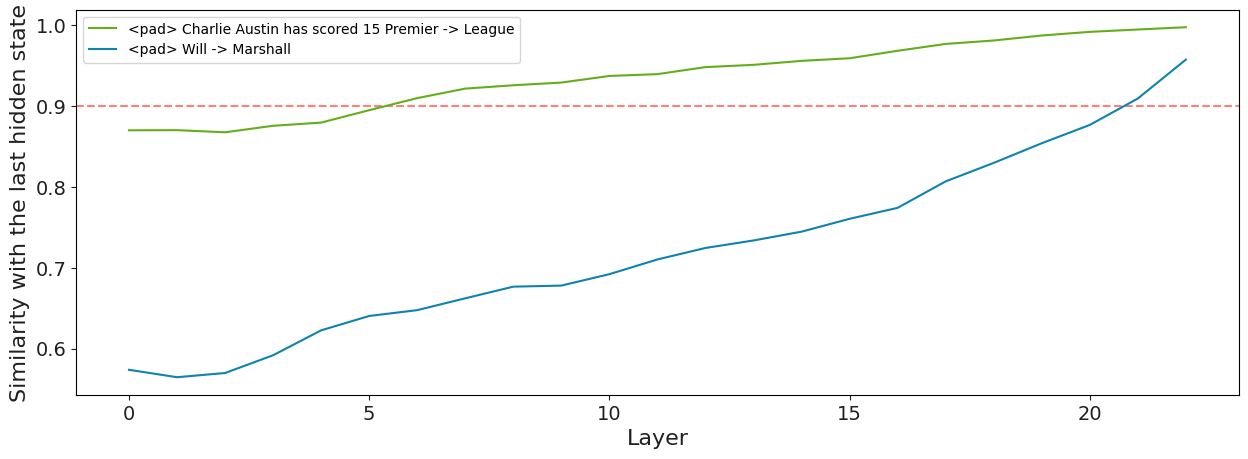

In [26]:
start_id = 1
colors = ["#64ae1a", "#0e83ae"]
plot_hidden_state_similarities(
    easy_sequences[start_id : start_id + 1] + hard_sequences[start_id : start_id + 1],
    0.9,
    save_path=f"../img/sequence_types/example_{start_id}",
    colors=colors,
    save_format=save_format,
)

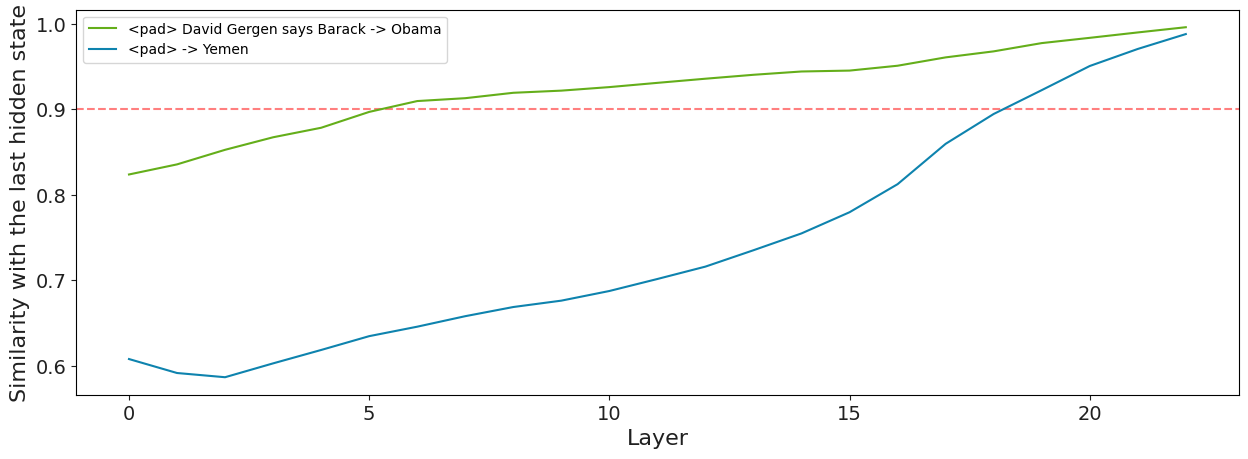

In [27]:
start_id = 58
colors = ["#64ae1a", "#0e83ae"]
plot_hidden_state_similarities(
    easy_sequences[start_id : start_id + 1] + hard_sequences[start_id : start_id + 1],
    0.9,
    save_path=f"../img/sequence_types/example_{start_id}",
    colors=colors,
    save_format=save_format,
)

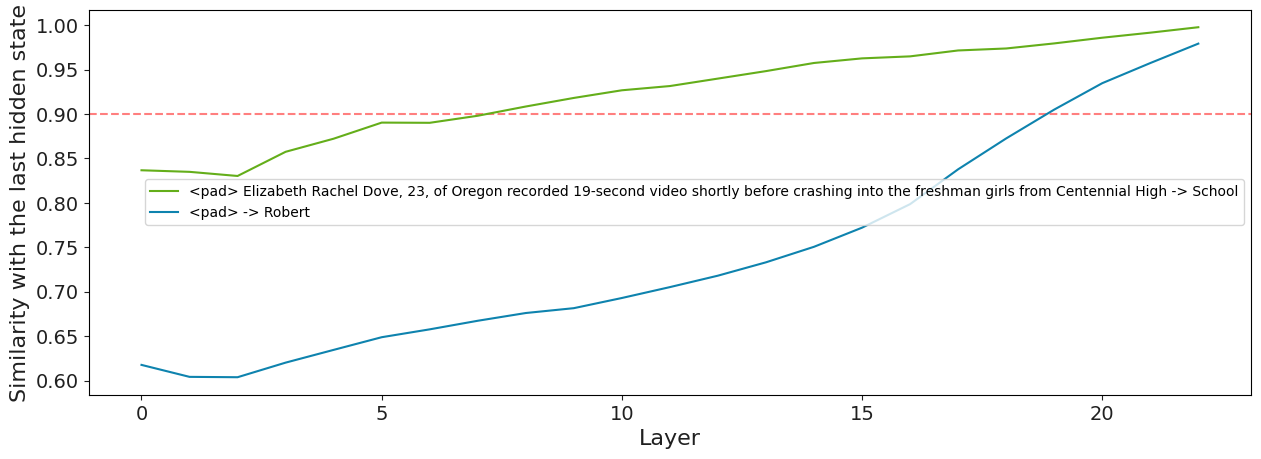

In [28]:
start_id = 59
colors = ["#64ae1a", "#0e83ae"]
plot_hidden_state_similarities(
    easy_sequences[start_id : start_id + 1] + hard_sequences[start_id : start_id + 1],
    0.9,
    save_path=f"../img/sequence_types/example_{start_id}",
    colors=colors,
    save_format=save_format,
)

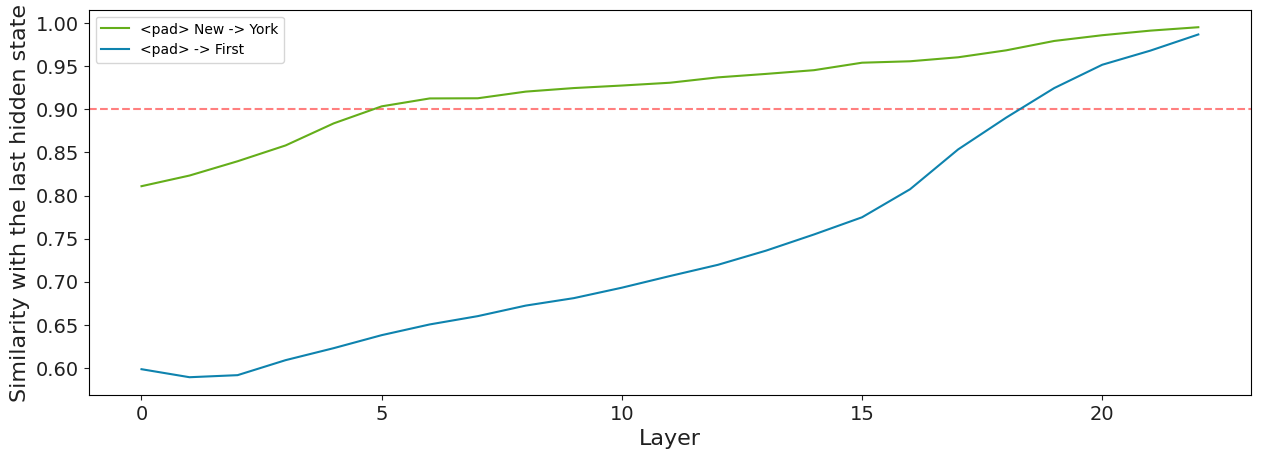

In [29]:
start_id = 64
colors = ["#64ae1a", "#0e83ae"]
plot_hidden_state_similarities(
    easy_sequences[start_id : start_id + 1] + hard_sequences[start_id : start_id + 1],
    0.9,
    save_path=f"../img/sequence_types/example_{start_id}",
    colors=colors,
    save_format=save_format,
)

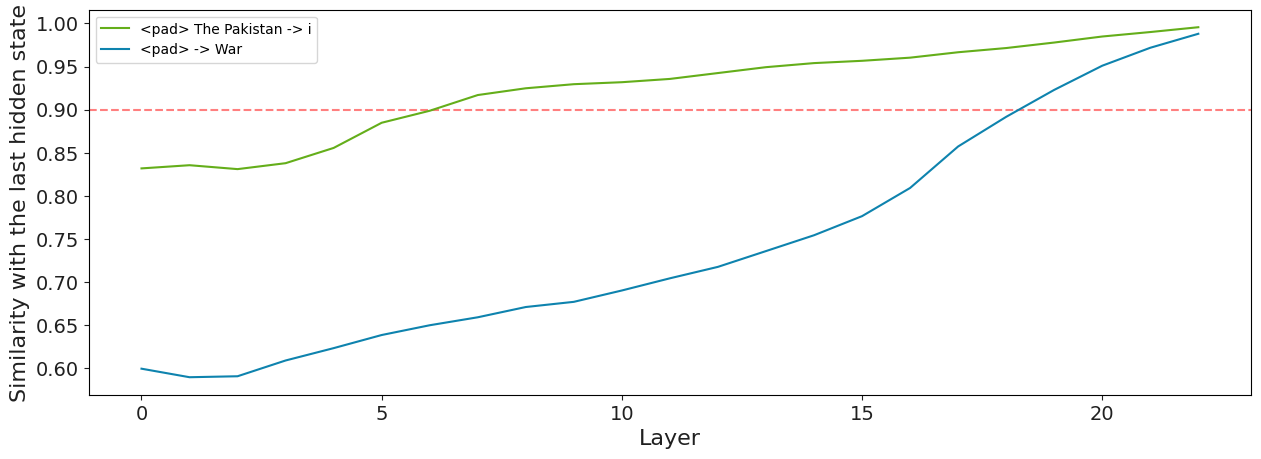

In [30]:
start_id = 65
colors = ["#64ae1a", "#0e83ae"]
plot_hidden_state_similarities(
    easy_sequences[start_id : start_id + 1] + hard_sequences[start_id : start_id + 1],
    0.9,
    save_path=f"../img/sequence_types/example_{start_id}",
    colors=colors,
    save_format=save_format,
)

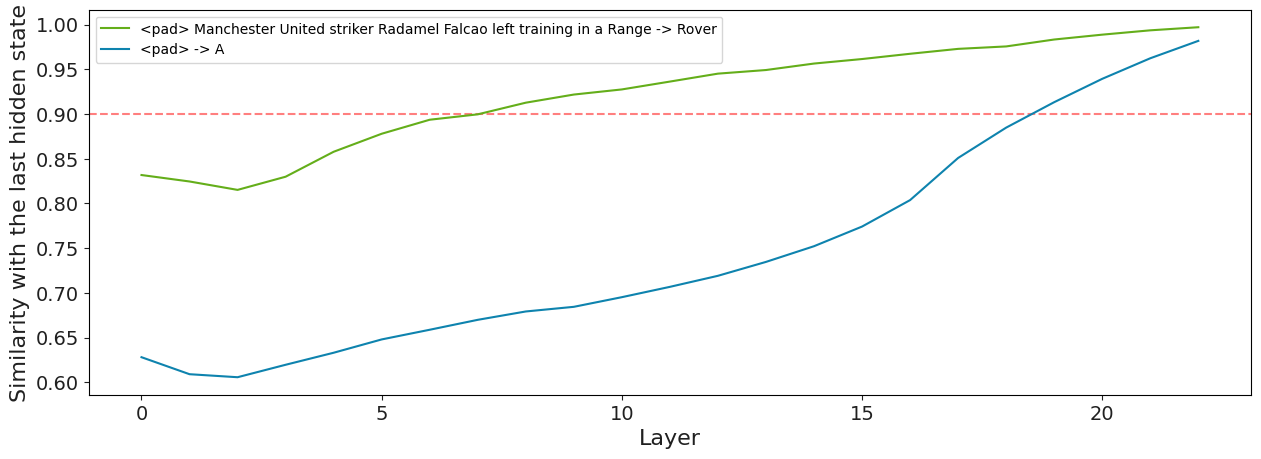

In [31]:
start_id = 85
colors = ["#64ae1a", "#0e83ae"]
plot_hidden_state_similarities(
    easy_sequences[start_id : start_id + 1] + hard_sequences[start_id : start_id + 1],
    0.9,
    save_path=f"../img/sequence_types/example_{start_id}",
    colors=colors,
    save_format=save_format,
)

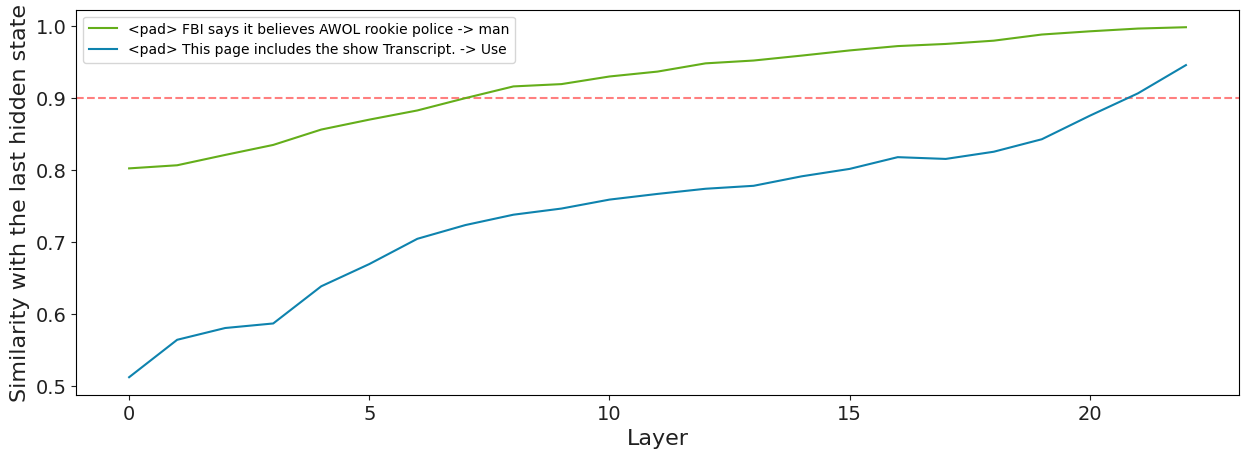

In [32]:
start_id = 93
colors = ["#64ae1a", "#0e83ae"]
plot_hidden_state_similarities(
    easy_sequences[start_id : start_id + 1] + hard_sequences[start_id : start_id + 1],
    0.9,
    save_path=f"../img/sequence_types/example_{start_id}",
    colors=colors,
    save_format=save_format,
)